In [1]:
%matplotlib inline

import numpy as np
import scipy.stats as stats
import scipy.special as special
import matplotlib.pyplot as plt
import matplotlib
import astropy.io.fits as fits

matplotlib.rc('xtick',labelsize=12)
matplotlib.rc('ytick',labelsize=12)

#read a sample velocity data
y = np.loadtxt('Vlos.dat')
print (type(y))

<class 'numpy.ndarray'>


Text(0.5,0,'V')

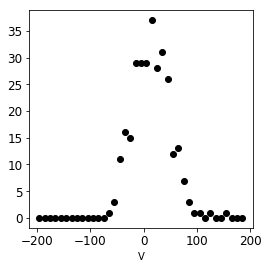

In [2]:
#draw histogram
vgrid = np.arange(-200,200,10)
vcenter = (vgrid[1:]+vgrid[:-1])/2.

hv,xedge = np.histogram(y,vgrid)

fig = plt.figure(figsize=[4,4])
ax = fig.add_subplot(111)
ax.plot(vcenter, hv, 'ko')
ax.set_xlabel('V')

In [3]:
#ask for the mean velocity and the velocity dispersion, 
#providing that the velocity distribution is Gaussian

#define functions needed
#define ln(Inv-gamma distribution), for scaled ln(Inv-chi-square)
def InvGammaln(x, alpha, beta):
    return np.log(beta)*alpha-(special.gammaln(alpha))+np.log(x)*(-alpha-1)-beta/x
#define ln(scaled Inv-chi-square)
def Scl_InvChi2ln(x, nu, s2):
    return InvGammaln(x, nu/2.,nu/2.*s2)
#rejection sampling for scaled Inv-chi-square
def randDraw_SInvChi2(nu, s2, N):
    x = []
    k = 0
    m = 0
    while k<N and m <= 3:
        x0 = np.random.uniform(low=0,high=2000,size=N*20)           #use U(0,2000) to generate x, N*20 numbers every time , for m=3 times
        y0 = np.log(np.random.uniform(low=0,high=0.006,size=N*20))  #use as rejection basis
        y1 = Scl_InvChi2ln(x0, nu, s2)                              #calculate f(x)
        
        ind = (y0<y1)           #acceptance
        x.append(x0[ind])       #accepted data stored in x           
        k = k + np.sum(ind)     #count the accepted data
        m += 1                  #count the times
    
    xx = np.array(x).reshape((k,1))  #reshape x(1,k) into xx(k,1)
    return (xx[0:N])

#data
n = len(y)                       #n, number of data
y_bar = np.mean(y)               #y_bar, mean of data
s2 = np.sum((y-y_bar)**2)/(n-1.) #s^2, unbiased sample variance
print (r'y_bar = %(y).3f km/s,  s2 = %(s).3f km^2/s^2' %{'y':y_bar, 's':s2})

y_bar = 14.260 km/s,  s2 = 1162.481 km^2/s^2


Text(0.5,0,'$\\sigma$')

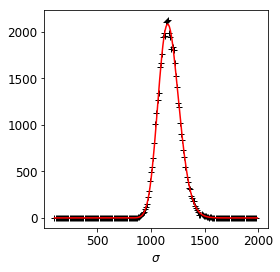

In [4]:
#solution 1: with prior blurred

#step 1: draw sigma2 from posterior density of 
#sigma2 given y, p(sigma2|y)
N = 50000
sigma2 = randDraw_SInvChi2(n-1,s2, N)

#draw the ditribution of sigma2|y
#analytical distribution
x = np.arange(100,2000,10) 
y1 = np.exp(Scl_InvChi2ln(x, n-1, s2))
#sampling histogram
hy,xedge = np.histogram(sigma2,x)
#draw picture
fig = plt.figure(figsize=[4,4])
ax = fig.add_subplot(111)
ax.plot(x[:-1],hy,'k+')
ax.plot(x,y1/sum(y1)*sum(hy),'r')
ax.set_xlabel(r'$\sigma$',fontsize=12)

(750, 1550)

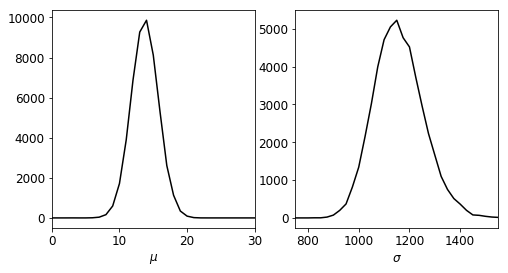

In [5]:
#step 2 : draw mu from p(mu|sigma2,y)
mu = np.random.normal(loc=y_bar, scale=np.sqrt(sigma2/n)) #bring every drawn sigma2 into the distribution to generate mu

#step 3: marginalize over sigma2
#sampling histogram
x = np.arange(-30,50,1)
hy,xedge = np.histogram(mu,x)      #mu
s = np.arange(500,2500,25)
hs,xedge = np.histogram(sigma2,s)  #sigma2

#draw the distribution density for mu
fig = plt.figure(figsize=[8,4])
ax = fig.add_subplot(121)
ax.plot(x[:-1],hy,'k')
ax.set_xlabel(r'$\mu$',fontsize=12)
ax.set_xlim([0,30])

#draw the distribution density for sigma
ax = fig.add_subplot(122)
ax.plot(s[:-1],hs,'k')
ax.set_xlabel(r'$\sigma$',fontsize=12)
ax.set_xlim([750,1550])

In [6]:
#obtain the statistics from the sampling
print ('mu = %(m).3f+/-%(s).3f' % {'m': np.mean(mu), 's': np.std(mu)})
print ('sigma = %(m).3f+/-%(s).3f' % {'m': np.mean(np.sqrt(sigma2)), 's': np.std(np.sqrt(sigma2))})

mu = 14.253+/-1.993
sigma = 34.186+/-1.419


[]

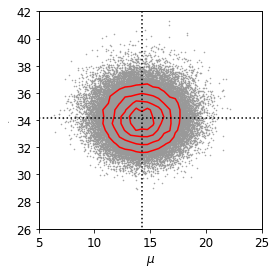

In [21]:
#draw joint posterior distribution for (mu, sigma)
xgrid = np.arange(-10,40,0.5)
ygrid = np.arange(25,45,0.5)
xcenter = (xgrid[:-1]+xgrid[1:])/2,
ycenter = (ygrid[:-1]+ygrid[1:])/2,
xmesh, ymesh = np.meshgrid(xcenter, ycenter)  #generate 2D grid

hmusig,xedge,yedge = np.histogram2d(mu.reshape((len(mu),)), np.sqrt(sigma2.reshape((len(sigma2),))), bins=[xgrid,ygrid])

fig = plt.figure(figsize=[4,4])
ax = fig.add_subplot(111)
ax.plot(mu,np.sqrt(sigma2),'.',color=[0.6,0.6,0.6],markersize=1)
ax1 = ax.twinx() #new axes: same and invisible x-axis, independent y-axis
ax1.contour(xmesh,ymesh,hmusig.T,6, colors='r',extent=[xcenter[0],xcenter[-1],ycenter[0],ycenter[-1]])
ax1.plot([np.mean(mu),np.mean(mu)],[0,100],'k:')
ax1.plot([-100,100],[np.mean(np.sqrt(sigma2)),np.mean(np.sqrt(sigma2))],'k:')
ax.set_xlabel(r'$\mu$',fontsize=12)
ax.set_ylabel(r'$\sigma$',fontsize=2)
ax.set_xlim([5,25])
ax.set_ylim([26,42])
ax1.set_xlim([5,25])
ax1.set_ylim([26,42])
ax1.set_yticks([])      #hide the y-axis of ax1

[]

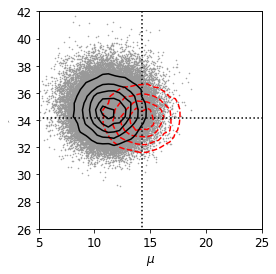

In [22]:
#solution2: consider a conjugate prior

#parameters of prior
mu0 = 3.
kappa0 = 100
nu0 = 10.0
sigma02 = 40**2

n = np.float(len(y))
N = 50000

#sample mean and variance
y_bar = np.mean(y)
s2 = np.sum((y-y_bar)**2)/(n-1)

#parameters of the posterior density
mun = kappa0*mu0/(kappa0+n)+n/(kappa0+n)*y_bar
kappan = kappa0+n
nun = nu0+n
nunsigman2 = nu0*sigma02+(n-1)*s2+kappa0*n*(y_bar-mu0)**2/(kappa0+n)


#approach 1: sampling one dimension by one dimension
#step 1: sample sigma2
sigma2_c = randDraw_SInvChi2(nun,nunsigman2/nun, N)
#step 2: sample mu
mu_c = np.random.normal(mun,np.sqrt(sigma2_c/kappan))

#draw joint distribution obtained from the sampling
hmusig_c,xedge,yedge = np.histogram2d(mu_c.reshape((len(mu_c),)), np.sqrt(sigma2_c.reshape((len(sigma2_c),))), bins=[xgrid,ygrid])

fig = plt.figure(figsize=[4,4])
ax = fig.add_subplot(111)
ax.plot(mu_c,np.sqrt(sigma2_c),'.',color=[0.6,0.6,0.6],markersize=1)
ax1 = ax.twinx()
ax1.contour(xmesh,ymesh,hmusig.T,6,linestyles='dashed',colors='r',extent=[xcenter[0],xcenter[-1],ycenter[0],ycenter[-1]])
ax1.contour(xmesh,ymesh,hmusig_c.T,6,colors='k',extent=[xcenter[0],xcenter[-1],ycenter[0],ycenter[-1]])
ax1.plot([np.mean(mu),np.mean(mu)],[0,100],'k:')
ax1.plot([-100,100],[np.mean(np.sqrt(sigma2)),np.mean(np.sqrt(sigma2))],'k:')
ax.set_xlabel(r'$\mu$',fontsize=12)
ax.set_ylabel(r'\ $\sigma$',fontsize=2)
ax.set_xlim([5,25])
ax.set_ylim([26,42])
ax1.set_xlim([5,25])
ax1.set_ylim([26,42])
ax1.set_yticks([])    #hide the y-axis of ax1

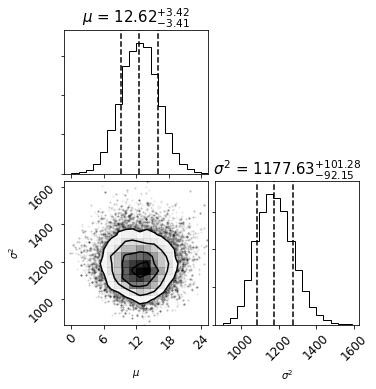

In [27]:
#approach 2: use MCMC for direct 2-D sampling
import emcee
import corner

def N_Scl_invChi2ln(x, mu,nu,kappa,sigma2):
    if x[1]<0:         #sigma should >0
        return -1e50
    else:
        return Scl_InvChi2ln(x[1],nu,sigma2)+stats.norm.logpdf(x[0],loc=mu, scale=x[1]/kappa)
    

n = np.float(len(y))

#sample mean and variance
y_bar = np.mean(y)
s2 = np.sum((y-y_bar)**2)/(n-1)

#parameters of the prior density
nu0 = 1.
sigma02 = 40**2
kappa0 = 50
mu0 = 3.
#parameters of the posterior density
mun = kappa0*mu0/(kappa0+n)+n/(kappa0+n)*y_bar
kappan = kappa0+n
nun = nu0+n
nunsigman2 = nu0*sigma02+(n-1)*s2+kappa0*n*(y_bar-mu0)**2/(kappa0+n)
sigman2 = nunsigman2/nun

#MCMC
#number of dimensions
ndim = 2
#number of chains
nwalkers = 50

#starting points of every chain in every dimension
p0=np.zeros((nwalkers,ndim))
p0[:,0] = np.random.rand(nwalkers)*30.-15.
p0[:,1] = np.random.rand(nwalkers)*50.+10.

#class emcee.EnsembleSampler(parameters)   
sampler = emcee.EnsembleSampler(nwalkers, ndim, N_Scl_invChi2ln, args=[mun,nun,kappan,sigman2])
#run from 'p0' with (burn-in) 100 steps, final position saved in 'pos'
pos, prob, state = sampler.run_mcmc(p0, 100)
#clear the chain 
sampler.reset()
#restart the sampler from 'pos' for 1000 steps
sampler.run_mcmc(pos, 1000)
#use sampler.chain.reshape((-1, ndim)) or sampler.flatchain 
samples = sampler.chain[:, 100:, :].reshape((-1, ndim))
#show the figure with corner
fig = corner.corner(samples,labels=[r"$\mu$", r"$\sigma^2$"],quantiles=[0.16, 0.5, 0.84],show_titles=True, title_kwargs={"fontsize": 15})